# **CATS AND DOGS CLASSIFICATION**

## **IMPORTED LIBRARIES**

In [1]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## **Loading the data**

In [2]:
data_path = "/kaggle/input/cd-deep/C_D"

# Define categories for classification (cats and dogs)
categories = ["cats", "dogs"]

# Define color categories for classification (black and white)
color_categories = ["black", "white"]

# Set the desired image size for resizing
img_size = 150

# Initialize an empty list to store image data and labels
data = []

for category in categories:
    for color_category in color_categories:
        # Construct the folder path for a specific category and color
        folder_path = os.path.join(data_path, category, color_category)

        # Assign labels: Dog/Cat label (0 for cats, 1 for dogs) and Color label (0 for black, 1 for white)
        label_dog_cat = categories.index(category)
        label_color = color_categories.index(color_category)
        
        for img in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img)

            # Check if the file format is an image (ending with specified extensions)
            if img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.webp')):
                try:
                    # Read and resize the image using OpenCV
                    img_array = cv2.imread(img_path)
                    img_array = cv2.resize(img_array, (img_size, img_size))

                    # Check if the image was successfully read and is not empty
                    if img_array is not None:
                        # Append image array, dog/cat label, and color label to the data list
                        data.append([img_array, label_dog_cat, label_color])
                    else:
                        # Print a message if the image is empty or cannot be read
                        print(f"Image {img_path} is empty or cannot be read.")
                except Exception as e:
                    # Print an error message if there's an exception while reading the image
                    print(f"Error reading image {img_path}: {str(e)}")

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


In [3]:
print("The size of data before the augmentation :",len(data)) 

The size of data before the augmentation : 1600


## **Adding data augmentation for the data**

In [4]:
# Separate features (images) and labels from the prepared data
x = np.array([entry[0] for entry in data]) 

# Extract labels for dog/cat classification (0 for cats, 1 for dogs)
y_dog_cat = np.array([entry[1] for entry in data])  # Extract dog/cat labels

# Extract labels for color classification (0 for black, 1 for white)
y_color = np.array([entry[2] for entry in data])  # Extract color labels

# Data Augmentation using Keras ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,  # Range for random rotations
    width_shift_range=0.2,  # Range for horizontal shifting
    height_shift_range=0.2,  # Range for vertical shifting
    horizontal_flip=True  # Enable horizontal flipping of images
)

# Create empty lists to store augmented data
augmented_x = []  # List to store augmented images
augmented_y_dog_cat = []  # List to store corresponding dog/cat labels for augmented images
augmented_y_color = []  # List to store corresponding color labels for augmented images


for i in range(len(x)):
    img = x[i]  # Select an image
    label_dog_cat = y_dog_cat[i]  # Retrieve its corresponding dog/cat label
    label_color = y_color[i]  # Retrieve its corresponding color label
    
    img = np.expand_dims(img, axis=0)  # Expand dimensions to fit the flow method's input shape
    j = 0  # Counter for augmented images
    # Generate augmented images using flow method from ImageDataGenerator
    for x_augmented in datagen.flow(img, batch_size=1):
        augmented_x.append(np.squeeze(x_augmented))  # Remove extra dimensions from augmented image
        augmented_y_dog_cat.append(label_dog_cat)  # Append corresponding dog/cat label for augmented image
        augmented_y_color.append(label_color)  # Append corresponding color label for augmented image
        j += 1
        if j == 11:  # Stop after generating 5 augmented images per original image
            break

## **Viewing the loaded data with its labels**

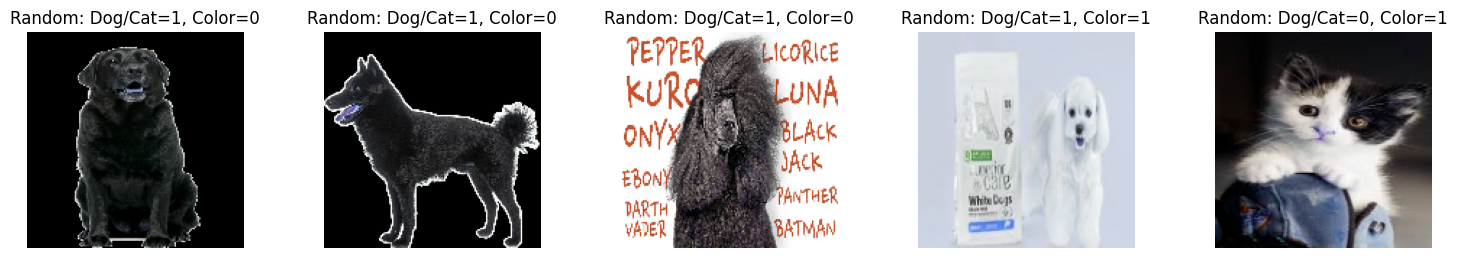

In [5]:
num_samples = 5

random_indices = random.sample(range(len(x)), num_samples)

# Display random images with corresponding labels
plt.figure(figsize=(15, 5))  
for i, idx in enumerate(random_indices):
    # Create subplots to display random images and their labels
    plt.subplot(2, num_samples, i + 1)
    
    # Display the random image corresponding to the generated index
    plt.imshow(x[idx]) 
    plt.title(f'Random: Dog/Cat={y_dog_cat[idx]}, Color={y_color[idx]}')  
    plt.axis('off')  
    
plt.tight_layout()  
plt.show()  

## **resizing, normalization and splitting the dataset into training, validation, and test sets.**

In [6]:
# Combine original and augmented data
x_combined = np.concatenate((x, np.array(augmented_x)))  
y_dog_cat_combined = np.concatenate((y_dog_cat, np.array(augmented_y_dog_cat)))  # Combine dog/cat labels
y_color_combined = np.concatenate((y_color, np.array(augmented_y_color)))  # Combine color labels

# Normalize the combined data by scaling pixel values between 0 and 1
x_combined = x_combined / 255.0

# Split combined data into training, validation, and test sets
x_train_val, x_test, y_train_val_dog_cat, y_test_dog_cat, y_train_val_color, y_test_color = train_test_split(
    x_combined, y_dog_cat_combined, y_color_combined, test_size=0.1, random_state=42
)

# Further split training and validation data
x_train, x_val, y_train_dog_cat, y_val_dog_cat, y_train_color, y_val_color = train_test_split(
    x_train_val, y_train_val_dog_cat, y_train_val_color, test_size=0.23, random_state=42
)

# Check the shapes of your augmented data
print("Train data shape:", x_train.shape)
print("Validation data shape:", x_val.shape)
print("Test data shape:", x_test.shape)

Train data shape: (13305, 150, 150, 3)
Validation data shape: (3975, 150, 150, 3)
Test data shape: (1920, 150, 150, 3)


In [7]:
print("The size of data after the augmentation :",len(x_combined))

The size of data after the augmentation : 19200


## **Change the labels to one hot encoders to be suitable for the training data**

In [8]:
y_train_dog_cat_one_hot = to_categorical(y_train_dog_cat)  # One-hot encode dog/cat labels in the training set
y_train_color_one_hot = to_categorical(y_train_color)  # One-hot encode color labels in the training set

y_val_dog_cat_one_hot = to_categorical(y_val_dog_cat)  # One-hot encode dog/cat labels in the validation set
y_val_color_one_hot = to_categorical(y_val_color)  # One-hot encode color labels in the validation set

y_test_dog_cat_one_hot = to_categorical(y_test_dog_cat)  # One-hot encode dog/cat labels in the test set
y_test_color_one_hot = to_categorical(y_test_color)  # One-hot encode color labels in the test set

## **THE CNN MODEL**

In [9]:
# Input layer
input_img = Input(shape=(150, 150, 3))  

# CNN model for feature extraction
x = Conv2D(32, (3, 3), activation='relu')(input_img)  # Convolutional layer with 32 filters and ReLU activation
x = BatchNormalization()(x)  # Batch normalization to normalize and stabilize activations
x = MaxPooling2D((2, 2))(x)  # Max pooling layer to downsample the spatial dimensions
x = Conv2D(64, (3, 3), activation='relu')(x)  # Convolutional layer with 64 filters and ReLU activation
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)  # Convolutional layer with 128 filters and ReLU activation
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)  # Flatten the output for dense layers
x = Dense(512, activation='relu')(x)  # Fully connected dense layer with 512 units and ReLU activation
x = Dropout(0.5)(x)  # Dropout layer with a dropout rate of 0.5 to prevent overfitting

# Task 1: Classify dogs or cats
fc1 = Dense(256, activation='relu')(x)  # Fully connected dense layer with 256 units and ReLU activation
fc1 = Dropout(0.5)(fc1)  # Dropout layer with a dropout rate of 0.5
output_dog_cat = Dense(2, activation='softmax', name='dog_cat')(fc1)  # Output layer for dog/cat classification

# Task 2: Classify color of the identified class 
fc2 = Dense(128, activation='relu')(x)  # Fully connected dense layer with 128 units and ReLU activation
fc2 = Dropout(0.5)(fc2)  # Dropout layer with a dropout rate of 0.5
output_color = Dense(2, activation='softmax', name='color')(fc2)  # Output layer for color classification

# Create a model with multiple outputs
model = Model(inputs=input_img, outputs=[output_dog_cat, output_color])  # Define a model with multiple outputs

In [10]:
# Define the initial learning rate for the optimizer
initial_learning_rate = 0.001

# Define a learning rate schedule using Exponential Decay
lr_schedule = ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

# Initialize an optimizer (RMSprop) with the defined learning rate schedule
optimizer = RMSprop(learning_rate=lr_schedule)

# Compile the model with appropriate loss functions for both tasks
model.compile(
    optimizer=optimizer,  
    loss={'dog_cat': 'categorical_crossentropy', 'color': 'categorical_crossentropy'},  # Specify losses for tasks
    metrics=['accuracy']  # Define evaluation metrics (accuracy)
)

In [11]:
# Define callbacks for early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5)  # Early stopping to prevent overfitting
model_checkpoint = ModelCheckpoint('cats_dogs.h5', monitor='val_loss', save_best_only=True)  # Model checkpoint to save the best model

# Fit the model using training and validation data
history = model.fit(
    x_train,  # Training data
    {'dog_cat': y_train_dog_cat_one_hot, 'color': y_train_color_one_hot},  
    validation_data=(x_val, {'dog_cat': y_val_dog_cat_one_hot, 'color': y_val_color_one_hot}),  
    epochs=10,  
    batch_size=64,  
    callbacks=[early_stopping, model_checkpoint]  # List of callbacks to be used during training
)

Epoch 1/10
208/208 [==============================] - ETA: 0s - loss: 6.8798 - dog_cat_loss: 5.0347 - color_loss: 1.8452 - dog_cat_accuracy: 0.5421 - color_accuracy: 0.8943

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


208/208 [==============================] - 33s 81ms/step - loss: 6.8798 - dog_cat_loss: 5.0347 - color_loss: 1.8452 - dog_cat_accuracy: 0.5421 - color_accuracy: 0.8943 - val_loss: 6.1022 - val_dog_cat_loss: 0.7151 - val_color_loss: 5.3870 - val_dog_cat_accuracy: 0.5213 - val_color_accuracy: 0.5728
Epoch 2/10
208/208 [==============================] - 13s 64ms/step - loss: 1.1998 - dog_cat_loss: 0.8244 - color_loss: 0.3754 - dog_cat_accuracy: 0.5432 - color_accuracy: 0.9366 - val_loss: 2.2411 - val_dog_cat_loss: 0.6881 - val_color_loss: 1.5531 - val_dog_cat_accuracy: 0.5328 - val_color_accuracy: 0.6511
Epoch 3/10
208/208 [==============================] - 13s 64ms/step - loss: 0.9223 - dog_cat_loss: 0.7331 - color_loss: 0.1892 - dog_cat_accuracy: 0.5569 - color_accuracy: 0.9550 - val_loss: 0.7885 - val_dog_cat_loss: 0.6816 - val_color_loss: 0.1069 - val_dog_cat_accuracy: 0.5716 - val_color_accuracy: 0.9716
Epoch 4/10
208/208 [==============================] - 13s 65ms/step - loss: 0.828

## **Plotting the loss and accuracy of the training**

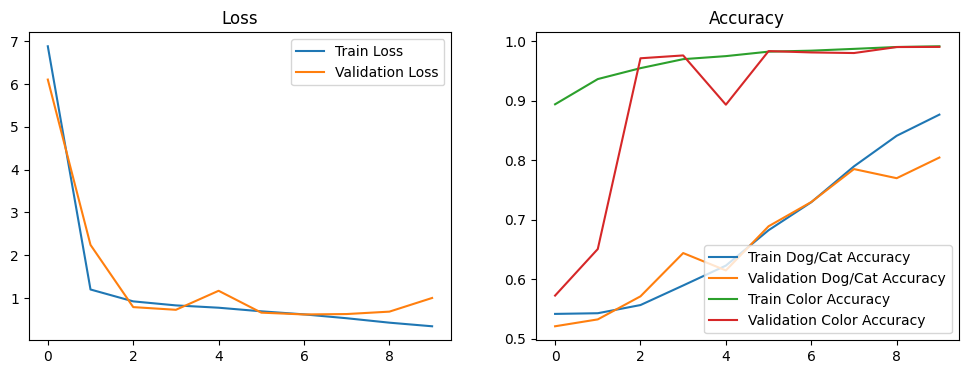

In [12]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['dog_cat_accuracy'], label='Train Dog/Cat Accuracy')
plt.plot(history.history['val_dog_cat_accuracy'], label='Validation Dog/Cat Accuracy')
plt.plot(history.history['color_accuracy'], label='Train Color Accuracy')
plt.plot(history.history['val_color_accuracy'], label='Validation Color Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()


## **Evaluate the model**

In [13]:
# Evaluate the trained model on the test data
total_loss, loss_dog_cat, loss_color, accuracy_dog_cat, accuracy_color = model.evaluate(
    x_test,  # Test input data
    {'dog_cat': y_test_dog_cat_one_hot, 'color': y_test_color_one_hot}  # Dictionary with test labels for tasks
)

# Display the evaluation metrics
print(f"Test Accuracy for dog/cat classification: {accuracy_dog_cat * 100:.2f}%")
print(f"Test Accuracy for color classification: {accuracy_color * 100:.2f}%")


60/60 [==============================] - 1s 12ms/step - loss: 1.1926 - dog_cat_loss: 1.0988 - color_loss: 0.0938 - dog_cat_accuracy: 0.7922 - color_accuracy: 0.9885
Test Accuracy for dog/cat classification: 79.22%
Test Accuracy for color classification: 98.85%


## **Classification report**

In [14]:
# Predictions
predictions = model.predict(x_test)
predicted_classes_dog_cat = np.argmax(predictions[0], axis=1)
predicted_classes_color = np.argmax(predictions[1], axis=1)

# Classification report
print("Classification Report for dog/cat classification:")
print(classification_report(y_test_dog_cat, predicted_classes_dog_cat))

print("Classification Report for color classification:")
print(classification_report(y_test_color, predicted_classes_color))


60/60 [==============================] - 1s 10ms/step
Classification Report for dog/cat classification:
              precision    recall  f1-score   support

           0       0.90      0.67      0.77       988
           1       0.72      0.92      0.81       932

    accuracy                           0.79      1920
   macro avg       0.81      0.80      0.79      1920
weighted avg       0.82      0.79      0.79      1920

Classification Report for color classification:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       959
           1       0.99      0.98      0.99       961

    accuracy                           0.99      1920
   macro avg       0.99      0.99      0.99      1920
weighted avg       0.99      0.99      0.99      1920



## **Predicting some images outside the data**

1/1 [==============================] - 0s 280ms/step


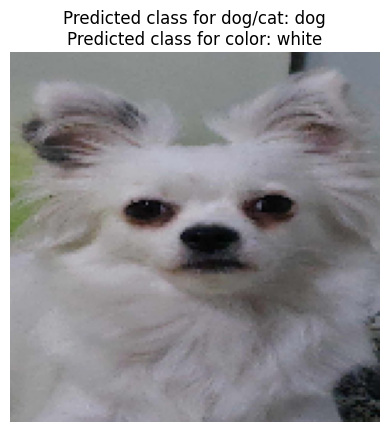

In [15]:
# Load the image
img = load_img('/kaggle/input/ebn-3amy/photo_2023-12-23_20-37-46.jpg', target_size=(150, 150))

# Convert the image to a numpy array
img_array = img_to_array(img)

# Scale the image pixels by 255 (or use the preprocess_input method if available for your base model)
img_array /= 255.

# Expand dimensions to fit the model's expected input format
img_array = np.expand_dims(img_array, axis=0)

# Define your class names
class_names_dog_cat = ['cat', 'dog']
class_names_color = ['black', 'white']

# Use the model to make a prediction
predictions = model.predict(img_array)

# Get the predicted classes
predicted_class_index_dog_cat = np.argmax(predictions[0], axis=1)[0]
predicted_class_index_color = np.argmax(predictions[1], axis=1)[0]

# Map the predicted class indices to class names
predicted_class_name_dog_cat = class_names_dog_cat[predicted_class_index_dog_cat]
predicted_class_name_color = class_names_color[predicted_class_index_color]

# Display the image and its predicted classes
plt.imshow(img)
plt.axis('off')  # Remove axis labels
plt.title(f"Predicted class for dog/cat: {predicted_class_name_dog_cat}\nPredicted class for color: {predicted_class_name_color}")
plt.show()